In [1]:
import os, sys
# HOME = os.environ['HOME']  # change if necessary
HOME = '/workspace/wilson'
sys.path.append(f'{HOME}/Finite-groups/src')

import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
from jaxtyping import Float
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
import pandas as pd
from typing import Union
from einops import repeat
from huggingface_hub import snapshot_download
from huggingface_hub.utils import disable_progress_bars


from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
from model_utils import *
from group_utils import *
from llc import *
from generalization_measures import *
from hessian import *
%load_ext autoreload
%autoreload 2

In [2]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [3]:
MODEL_DIR = '2025-01-19_02-04-16_S5_MLP2_128_wd2e-5_inst1'
disable_progress_bars()
local_dir = f'{HOME}/models/{MODEL_DIR}'
if not os.path.exists(local_dir):
    snapshot_download(repo_id='wiwu2390/{MODEL_DIR}', local_dir=local_dir)
models, params = load_models(local_dir, sel=slice(0, -1, 3))

# IMPORTANT: set seed before creating data (which samples train_data)
t.manual_seed(params.seed)
np.random.seed(params.seed)
random.seed(params.seed)

data = GroupData(params)
init_models = MLP2.stack([models[0]] * len(models)).to(device)
models = MLP2.stack(models).to(device)

  0%|          | 0/667 [00:00<?, ?it/s]/workspace/wilson/Finite-groups/src/model_utils.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(mode

Intersection size: 14400/14400 (1.00)
Added 14400 elements from intersection
Added 0 elements from group 0: S(5)
Taking random subset: 5760/14400 (0.40)
Train set size: 5760/14400 (0.40)


In [10]:
loss_dict = load_loss_trajectory(local_dir)
loss_dict = {k: v.squeeze()[::3] for k, v in loss_dict.items()}
loss_dict['gen_error'] = loss_dict['epoch_train_acc'] - loss_dict['G0_acc']

/workspace/wilson/Finite-groups/src/utils.py:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  losses = [t.load(f) for f in loss_files if 'final.pt' not in f]


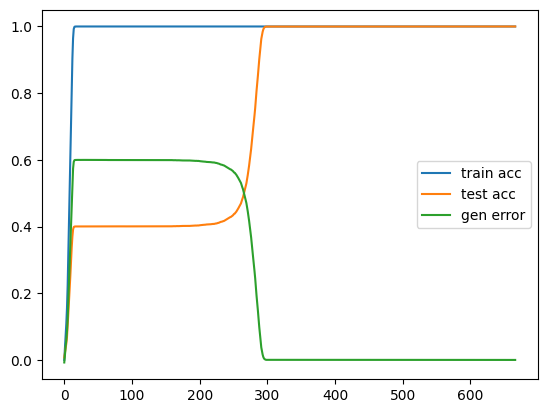

In [5]:
plt.plot(loss_dict['epoch_train_acc'].squeeze().cpu().detach().numpy(), label='train acc')
plt.plot(loss_dict['G0_acc'].squeeze().cpu().detach().numpy(), label='test acc')
plt.plot(loss_dict['gen_error'].squeeze().cpu().detach().numpy(), label='gen error')
plt.legend()
plt.show()

In [8]:
# measures = dict()
measures |= get_gen_measures(init_models, models, data)

MARGIN
NORMS
PATH_NORM
PACBAYES


DOUBLING:   0%|          | 0/15 [00:00<?, ?it/s]

BINARY SEARCH:   0%|          | 0/15 [00:00<?, ?it/s]

WARN: Binary search with depth 15 failed to converge for 21 instances!
PACBAYES_MAG


DOUBLING:   0%|          | 0/15 [00:00<?, ?it/s]

BINARY SEARCH:   0%|          | 0/15 [00:00<?, ?it/s]

WARN: Binary search with depth 15 failed to converge for 31 instances!


In [6]:
LLC_PARAMS = {
    'eps': 8e-4,
    'beta': 1e3,
    'gamma': 1.,
    'chains': 5,
    'cbatch_size': 1,
    'replacement': False,
    'behavioral': False,
    'epochs': 3000,
}
llc, traces = get_llc(models, data, **LLC_PARAMS)

SGLD:   0%|          | 0/3000 [00:00<?, ?it/s]

SGLD:   0%|          | 0/3000 [00:00<?, ?it/s]

SGLD:   0%|          | 0/3000 [00:00<?, ?it/s]

SGLD:   0%|          | 0/3000 [00:00<?, ?it/s]

SGLD:   0%|          | 0/3000 [00:00<?, ?it/s]

In [10]:
measures['LLC'] = llc

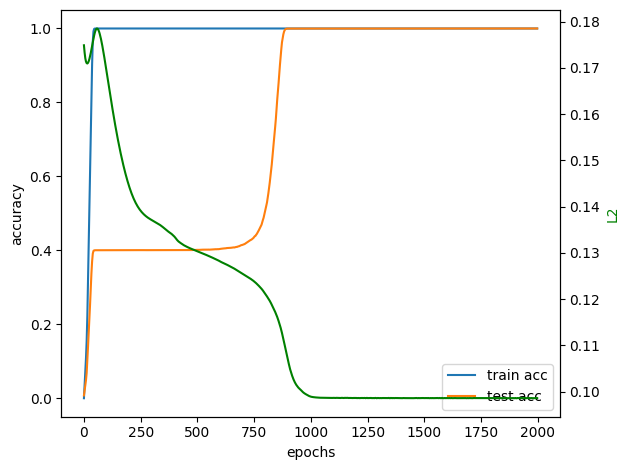

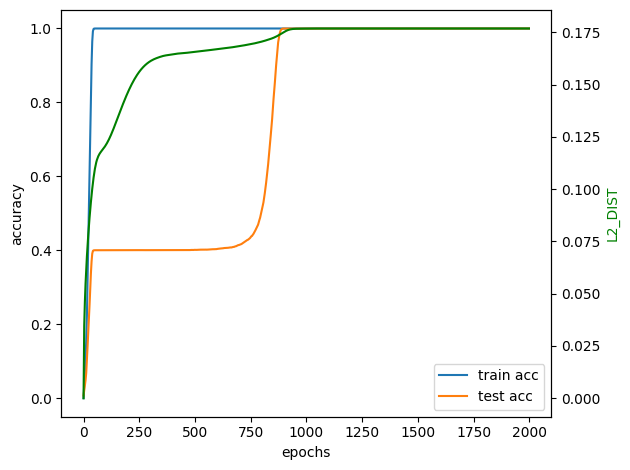

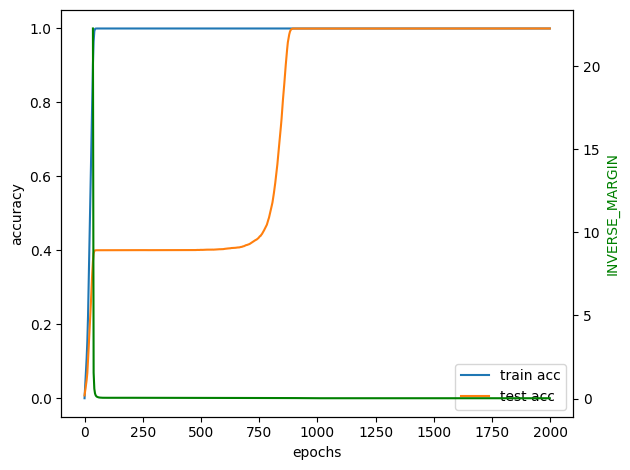

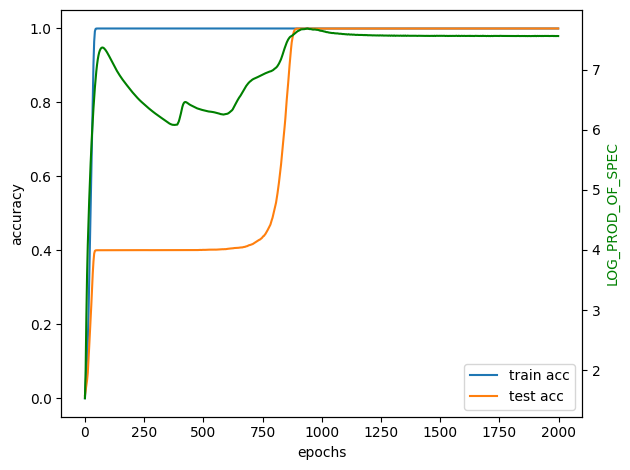

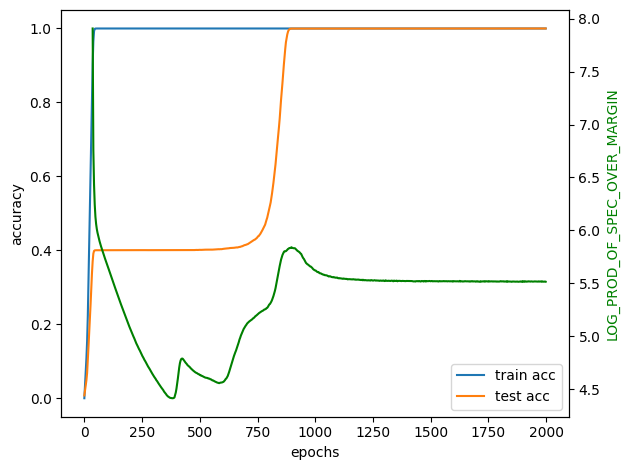

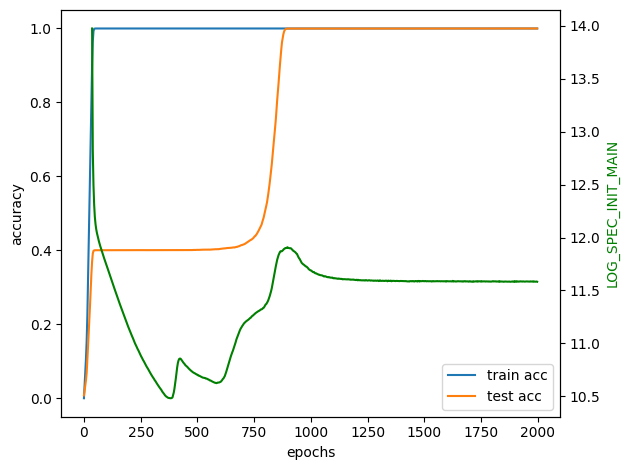

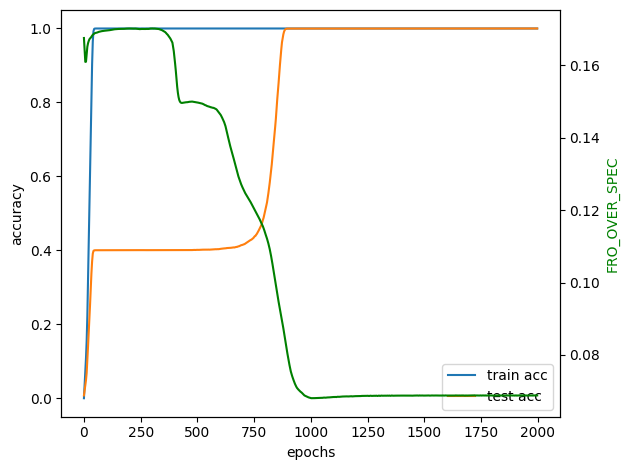

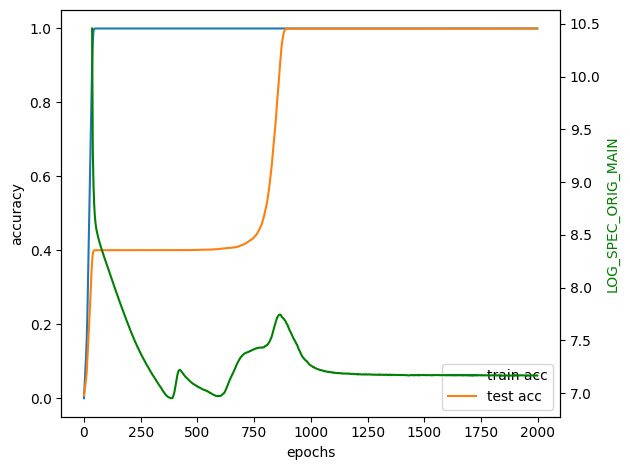

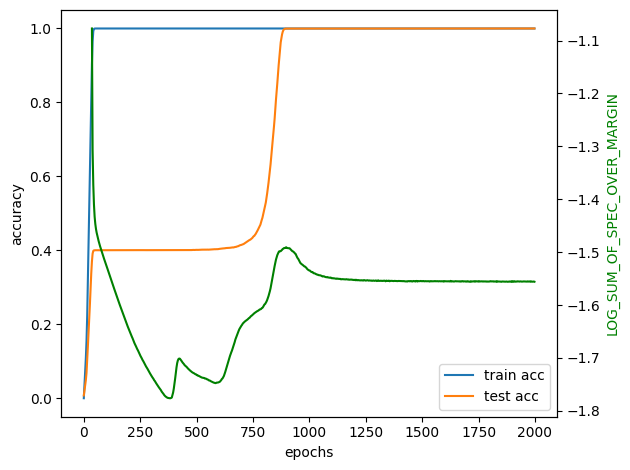

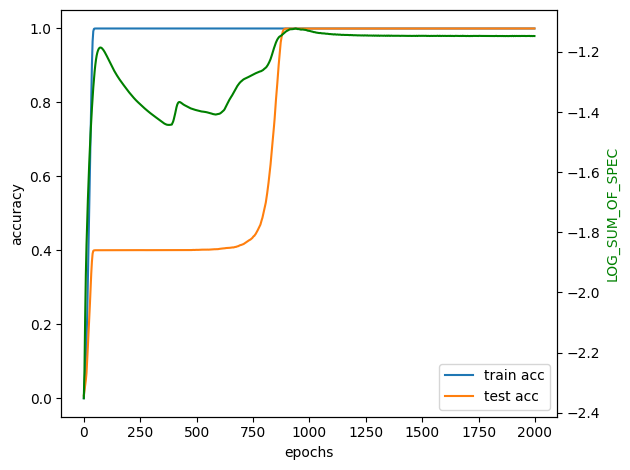

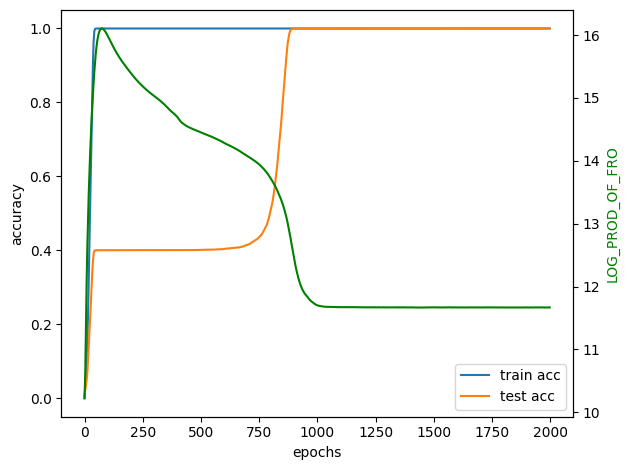

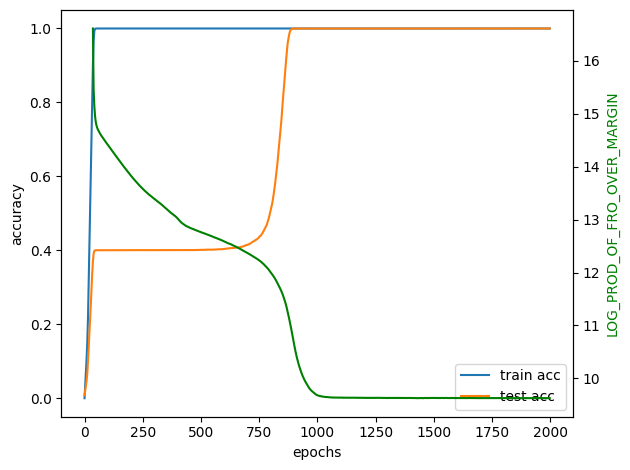

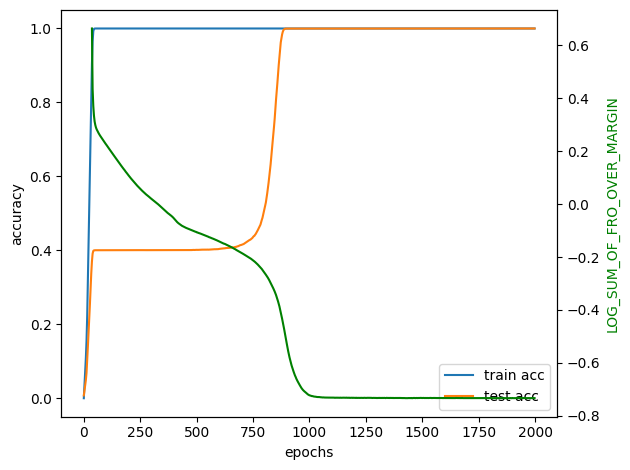

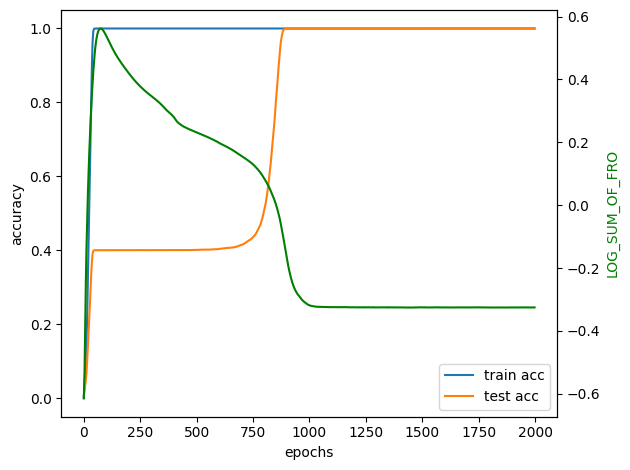

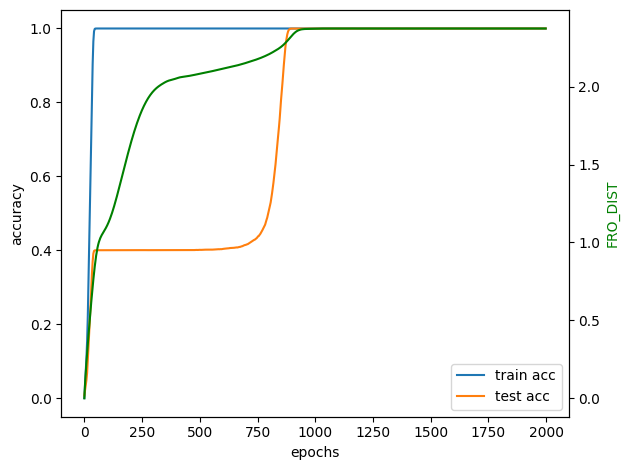

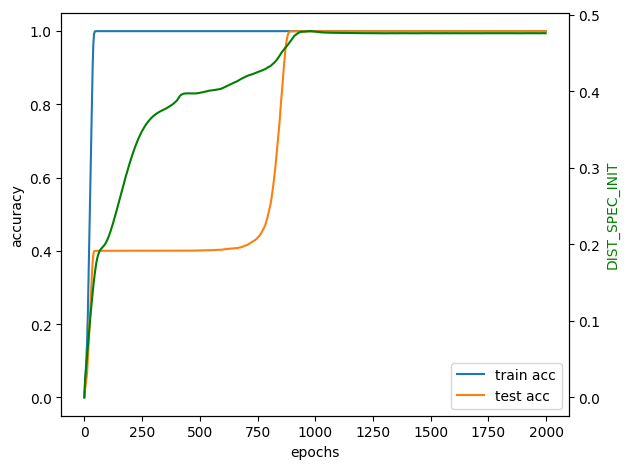

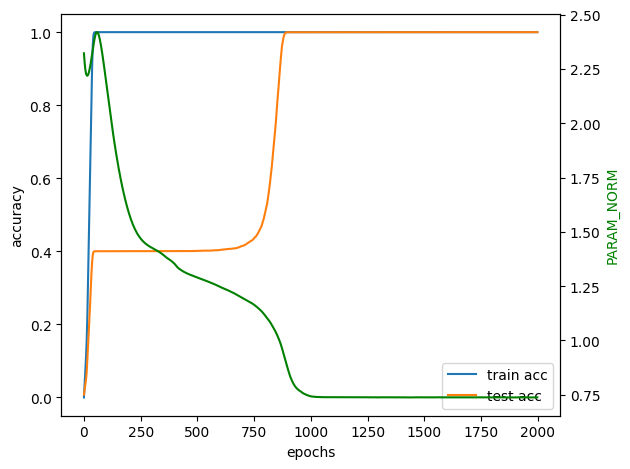

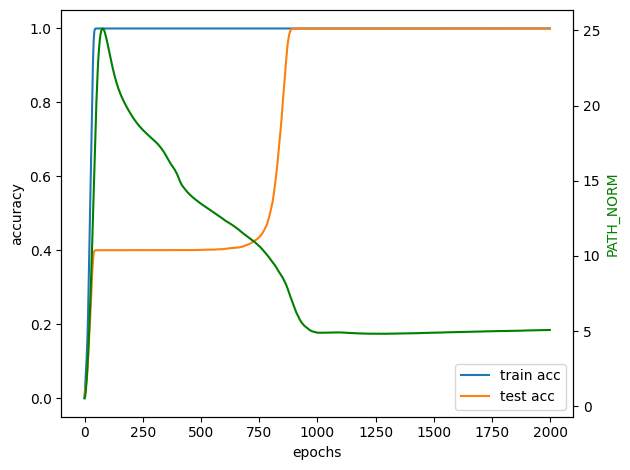

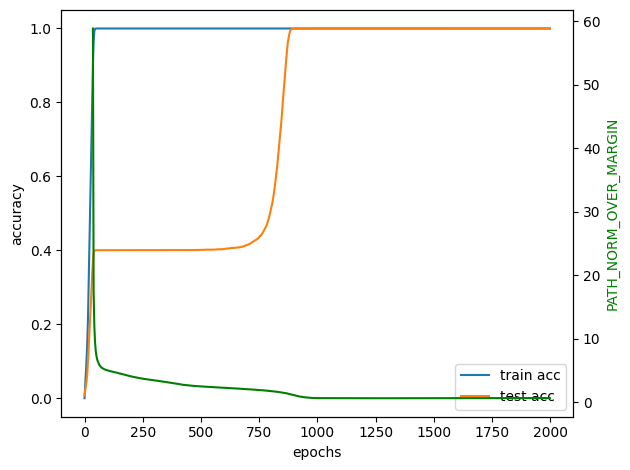

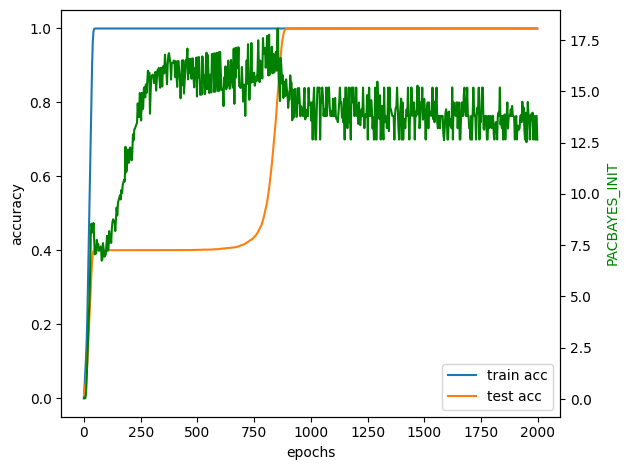

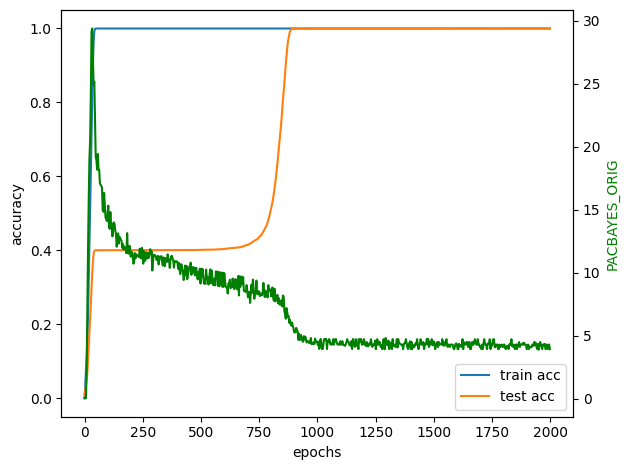

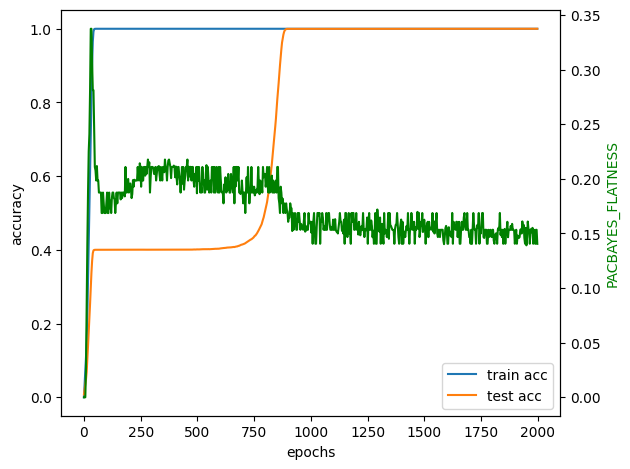

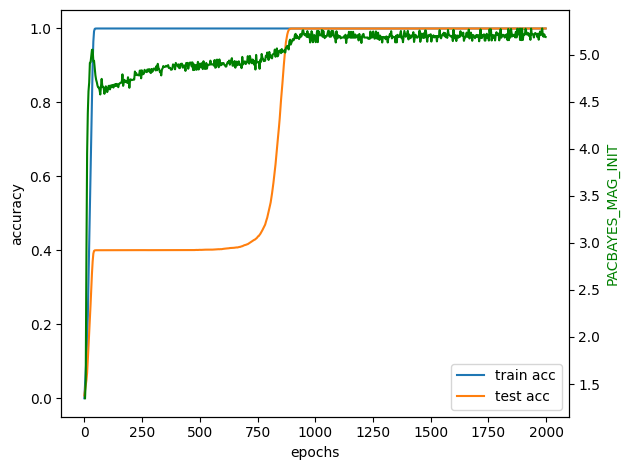

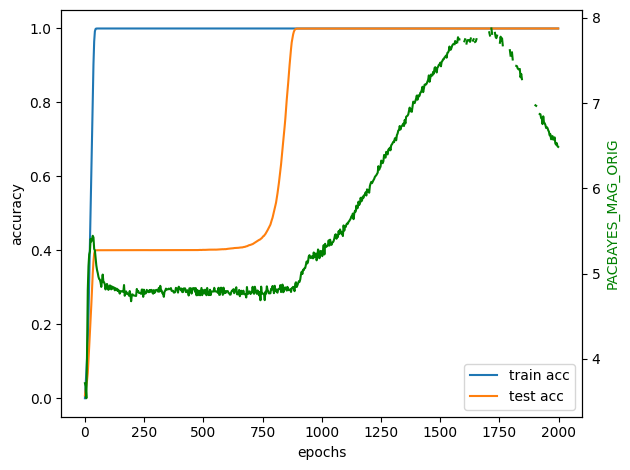

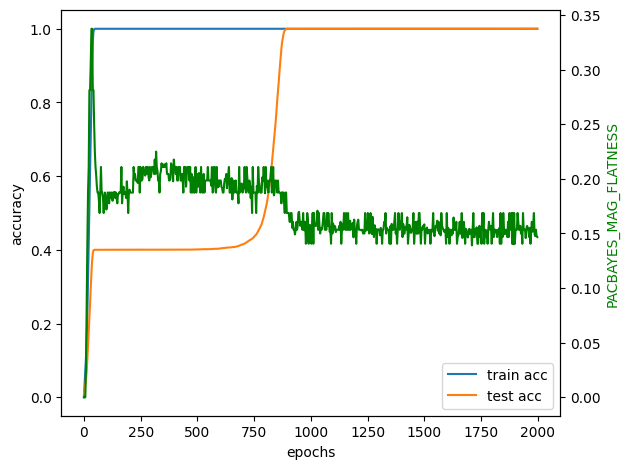

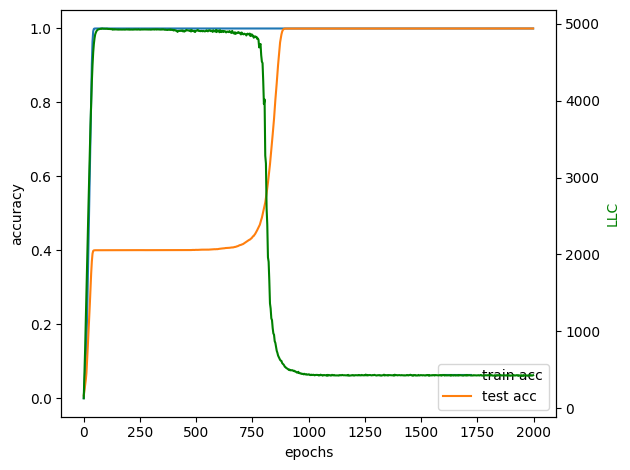

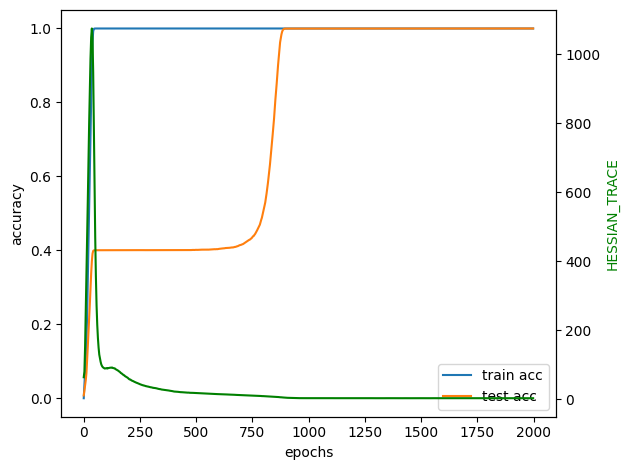

In [11]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

epochs = np.arange(0, 2000, 3)

for k, v in measures.items():
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('epochs')
    ax1.set_ylabel('accuracy')
    ax1.plot(epochs, loss_dict['epoch_train_acc'].cpu().numpy(), label='train acc')
    ax1.plot(epochs, loss_dict['G0_acc'].cpu().numpy(), label='test acc')
    ax1.legend()

    ax2 = ax1.twinx()

    ax2.set_ylabel(k, c='green')  # we already handled the x-label with ax1
    ax2.plot(epochs, v.detach().cpu().numpy(), label=k, c='green')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

    

    # fig = make_subplots(specs=[[{"secondary_y": True}]])
    # fig.add_trace(
    #     go.Scatter(x=epochs, y=v.detach().cpu().numpy(), name=k),
    #     secondary_y=True,
    # )
    # fig.add_trace(
    #     go.Scatter(x=epochs, y=loss_dict['epoch_train_acc'].cpu().numpy(), name="train acc"),
    #     secondary_y=False,
    # )
    # fig.add_trace(
    #     go.Scatter(x=epochs, y=loss_dict['G0_acc'].cpu().numpy(), name="test acc"),
    #     secondary_y=False,
    # )
    # fig.update_xaxes(title_text="epoch")
    # fig.update_yaxes(title_text="accuracy", secondary_y=False)
    # fig.update_yaxes(title_text="measure", secondary_y=True)
    # fig.show()

In [8]:
t.save(measures, '/workspace/wilson/Finite-groups/data/S5_measures.pt')
# measures = t.load('/workspace/wilson/Finite-groups/data/S5_measures.pt')

In [7]:
measures['HESSIAN_TRACE'] = h_tr(models, data)

  0%|          | 0/667 [00:00<?, ?it/s]